In [1]:
import torch
import torch.nn as nn
import numpy as np 
import random
import tqdm

In [2]:
device = torch.device("cuda:6")

H = torch.load("test/original_weights.pt")["H"].to(device).float()
weights = torch.load("test/original_weights.pt")["weights"].to(device).float()    

In [3]:
import sklearn.cluster as cluster

In [4]:
def cluster_e_step(X,centriods,
                   weights):
    
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    weights: torch.tensor of shape (n,d)
    """

    # k = centriods.shape[0]

    errors = (X.unsqueeze(-1) - centriods.T.unsqueeze(0))**2
    #shape of (n, d, k)

    #multiply by the diagonal
    errors = errors * weights.unsqueeze(-1)

    #sum by the d
    errors = errors.sum(1)
    # print("errors[0,10,:] = ", errors[0,10,:])
    #shape of (n, k)
    # print(errors[0,10,:])
    assignments = errors.argmin(-1)
    # print("assignments[0,10] = ", assignments[0,10])
    # print("="*10)
    #shape of (n)
    return assignments


def cluster_m_step(X, assignments, k, weights):
    """
    X: torch tensor of the weights, rearanged into a shape of (n, d)
    assignments: torch.tensor of the assignments, shape of (n)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    """
    n, d = weights.shape

    #compute the new centriods
    centriods = torch.zeros((k,d), dtype = weights.dtype, device = weights.device)
    #shape of (k,d)
    for i in range(k):
        assignment_X = X[assignments == i] #shape of (n_i,d)
        assignments_weights = weights[assignments == i] #shape of (n_i,d)

        centriods[i] = torch.sum(assignments_weights * assignment_X, dim = 0) / torch.sum(assignments_weights, dim = 0)

    return centriods


def our_cluster(X, k, weights, n_iter = 100,
            centriods = None):
    """
    weights: torch tensor of the weights, rearanged into a shape of (n, d)
    k: int, number of clusters
    weights: torch.tensor of shape (n, d)
    n_iter: int, number of iterations
    """
    n, d = weights.shape

    #randomly select k centriods
    if centriods is None:
        n_1 = torch.from_numpy(np.random.choice(n, k, replace = False)).to(device)
        centriods = X[n_1, :]
        # print(centriods)
    #shape of (k, d)
    for i in range(n_iter):
        # print("X.shape = ", X.shape, "centriods.shape = ", centriods.shape, "weights.shape = ", weights.shape)
        assignments = cluster_e_step(X, centriods, weights)
        # print(assignments)
        # print(assignments.shape)
        centriods = cluster_m_step(X, assignments, k, weights)
        if i > 0:
            if torch.all(assignments == assignments_old):
                # print("breaking at iteration", i)
                break
            # print("n_change:", torch.sum(assignments != assignments_old))
        assignments_old = assignments.clone()
    return assignments, centriods
    

def reconstruct_cluster(assignments, centriods):
    """
    assignments: torch.tensor of the assignments, shape of (n, m/d)
    centriods: torch.tensor of the centriods, shape of (k, d)
    H_diag: torch.tensor of shape (m/d,d)
    """
    reconstructed_X = centriods[assignments,:]
    #shape of (n, m/d, d)
    return reconstructed_X


In [5]:
def bin_entropy(values, bins:int = 100,eps = 1e-5):
    """
    values: torch.tensor of the values
    bins: int, number of bins
    """
    hist = torch.histc(values, bins = bins)
    hist = hist + eps
    hist = hist / hist.sum()
    # print(hist)
    # print(torch.log2(hist))
    entropy = - (hist * torch.log2(hist)).sum()
    return entropy

In [6]:
H

tensor([[ 7.1563,  0.5674, -0.0539,  ...,  0.0605,  0.4753, -0.3956],
        [ 0.5674,  2.0979, -0.1735,  ..., -0.1154,  0.2205, -0.1745],
        [-0.0539, -0.1735,  1.1984,  ..., -0.0545,  0.0118, -0.0629],
        ...,
        [ 0.0605, -0.1154, -0.0545,  ...,  2.6129,  0.0111, -0.1244],
        [ 0.4753,  0.2205,  0.0118,  ...,  0.0111,  1.7452, -0.0740],
        [-0.3956, -0.1745, -0.0629,  ..., -0.1244, -0.0740,  2.0673]],
       device='cuda:6')

In [7]:
H = torch.clip(H, -1e5, 1e5)

In [8]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
import tqdm
import sklearn.cluster

n_iters = 25

d = 4
k_magnitude_codebook = 1
k_coseine_codebook = 16**2
keep_top = 0.01

# print("average bits:", (np.log2(k_magnitude_codebook) + np.log2(k_coseine_codebook))/d)

overhead = k_magnitude_codebook * 16 + k_coseine_codebook * k_magnitude_codebook * 16
sparse_bits = 16* weights.shape[0] * weights.shape[1] * keep_top
encoding_bits = (np.ceil(np.log2(k_magnitude_codebook)) + np.ceil(np.log2(k_coseine_codebook)))/d * weights.shape[0] * weights.shape[1]
print("overhead = ", overhead/(weights.shape[0]*weights.shape[1]), "encoding_bits = ", encoding_bits/(weights.shape[0]*weights.shape[1]), "sparse_bits = ", sparse_bits/(weights.shape[0]*weights.shape[1]))
print("average_bits = ", (encoding_bits+ sparse_bits + overhead)/(weights.shape[0]*weights.shape[1]))
# raise ValueError

row_assignments = torch.arange(weights.shape[1]).reshape(-1, d)
# row_assignments = torch.randperm(weights.shape[1]).reshape(-1, d)

assert torch.isfinite(weights).all()
assert torch.isfinite(H).all()

weights_reshaped = weights[:,row_assignments] 
print("weights_reshaped.shape = ", weights_reshaped.shape)
#shape of (n, m/d, d)

H_diag = torch.diag(H)[row_assignments].unsqueeze(0).expand(weights_reshaped.shape[0], -1, -1)
# H_diag = torch.ones_like(weights_reshaped)
#shape of (n, m/d, d)

weights_norms = torch.norm(weights_reshaped, dim = -1)
# print(H[:,row_assignments].shape)
H_norms = torch.norm(H[:,row_assignments], dim = (0,-1))
print(H_norms)
mask_H = H_norms < torch.quantile(H_norms.float(), 1-keep_top/2)
print(torch.quantile(H_norms.float(), 1-keep_top/2))
mask_H = mask_H.unsqueeze(0).expand(weights.shape[0], -1)
print(mask_H)

mask_norm = weights_norms < torch.quantile(weights_norms.float(), 1-keep_top/2).half()

mask = mask_norm & mask_H

# raise ValueError
# print(torch.quantile(weights_norms, 1-keep_top), torch.max(weights_norms), torch.min(weights_norms))
# print(torch.sum(mask)/(mask.shape[0]*mask.shape[1]), 1 - torch.sum(mask)/(mask.shape[0]*mask.shape[1]))
# raise ValueError
#mask of the top 1% of the weights

weights_norms_masked = weights_norms[mask]
weights_use = weights_reshaped[mask,:]  #/weights_norms_masked.unsqueeze(-1)
H_diag_use = H_diag[mask,:] #* weights_norms_masked.unsqueeze(-1)**2
# H_diag_use = torch.clip(H_diag_use, 0,100)

print("weights_norms_masked.shape", weights_norms_masked.shape)
print("weights_masked.shape = ", weights_use.shape)
print("H_diag_use.shape = ", H_diag_use.shape)


# #first we get the magnitude codebook
# magnitude_assignments, magnitude_codebook = our_cluster(torch.log(weights_norms_masked).unsqueeze(-1), k_magnitude_codebook, 
#                                                         torch.ones_like(weights_norms_masked).unsqueeze(-1),
#                                                          n_iter = 1000)

#try binning the magnitudes
# magnitude_codebook = np.linspace(np.log(weights_norms_masked.min()), np.log(weights_norms_masked.max()), k_magnitude_codebook).reshape(-1,1)
# magnitude_assignments = np.argmin(np.abs(np.log(weights_norms_masked.numpy()).reshape(-1,1) - magnitude_codebook.T), axis = 1)
# print("magnitude_codebook = ", magnitude_codebook)
# print("magnitude_assignments = ", magnitude_assignments)


codebooks = {}
assignments_dict = {}
for i in tqdm.tqdm(range(k_magnitude_codebook)):
    # mask_i = magnitude_assignments == i
    # if torch.sum(mask_i) <= k_coseine_codebook:
    #     codebooks[i] = weights_use[mask_i,:]
    #     assignments_dict[i] = torch.arange(torch.sum(mask_i).item())
    #     continue

    # assignments, centriods = our_cluster(weights_use[mask_i,:], k_coseine_codebook, H_diag_use[mask_i,:], n_iter = n_iters)
    assignments, centriods = our_cluster(weights_use, k_coseine_codebook, H_diag_use, n_iter = n_iters)
    codebooks[i] = centriods
    assignments_dict[i] = assignments


weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]

for i in range(k_magnitude_codebook):
    # mask_i = magnitude_assignments == i
    # mask_ = torch.zeros_like(mask)
    # mask_[mask] = mask_i
    # weights_reconstructued_flat[mask_,:] = codebooks[i][assignments_dict[i],:] #* torch.exp(magnitude_codebook[i,0])
    weights_reconstructued_flat[mask,:] = codebooks[i][assignments_dict[i],:] 
# weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


weights_reconstructued = torch.empty_like(weights)

weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)


diff = weights - weights_reconstructued

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print(f"average error {average_error}, H error {H_error}")

overhead =  0.00024509429931640625 encoding_bits =  2.0 sparse_bits =  0.16
average_bits =  2.1602450942993165
weights_reshaped.shape =  torch.Size([4096, 1024, 4])
tensor([76.5444, 24.4887, 28.5600,  ..., 39.8064, 32.6342, 36.4311],
       device='cuda:6')
tensor(5308.5708, device='cuda:6')
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:6')
weights_norms_masked.shape torch.Size([4151722])
weights_masked.shape =  torch.Size([4151722, 4])
H_diag_use.shape =  torch.Size([4151722, 4])


100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

average error 0.37644776701927185, H error 3.154137134552002


In [24]:
H[~torch.isfinite(H)]

tensor([], device='cuda:6')

In [11]:
codebooks_use = {}
for i in range(k_magnitude_codebook):
    codebooks_use[i] = codebooks[i].clone().requires_grad_(True)


n_iters = 100
lr = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10

for i in range(n_iters):
    weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

    weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
    # print(codebooks_use[0])
    # for i in range(k_magnitude_codebook):
    #     mask_i = torch.from_numpy(magnitude_assignments == i)
    #     assert torch.any(mask_i)
    #     mask_ = torch.zeros_like(mask)
    #     mask_[mask] = mask_i
    weights_reconstructued_flat[mask,:] = codebooks_use[0][assignments_dict[0],:]
    # weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    print(f"average error {average_error}, H error {H_error}")
    H_error.backward()

    if H_error > prev_loss:
        lr = lr/2
        print("reducing lr to ", lr)
    prev_loss = H_error.item()
    with torch.no_grad():
        for i in range(k_magnitude_codebook):
            # print(codebooks_use[i].grad)
            codebooks_use[i] -= torch.clip(lr * codebooks_use[i].grad, -clamp_gradients, clamp_gradients)
            # codebooks_use[i] = codebooks_use[i].clamp(-1,1)
        # raise ValueError
        for i in range(k_magnitude_codebook):
            codebooks_use[i].grad = None


average error 0.37644776701927185, H error 3.154137134552002
average error 0.37828323245048523, H error 2.913954019546509
average error 0.37856239080429077, H error 2.839836359024048
average error 0.3793538510799408, H error 2.7912096977233887
average error 0.3799650967121124, H error 2.7531731128692627
average error 0.38058894872665405, H error 2.722217559814453


average error 0.3811722695827484, H error 2.696550130844116
average error 0.38173148036003113, H error 2.674983501434326
average error 0.3822632431983948, H error 2.656667709350586
average error 0.38276922702789307, H error 2.640970230102539
average error 0.3832501173019409, H error 2.6274094581604004
average error 0.383706659078598, H error 2.615610122680664
average error 0.3841400742530823, H error 2.605276107788086
average error 0.3845512866973877, H error 2.5961720943450928
average error 0.3849412798881531, H error 2.588107109069824
average error 0.3853112459182739, H error 2.580925226211548
average error 0.38566234707832336, H error 2.57450008392334
average error 0.38599565625190735, H error 2.568725824356079
average error 0.3863123953342438, H error 2.5635151863098145
average error 0.38661327958106995, H error 2.5587942600250244
average error 0.386899471282959, H error 2.554502010345459
average error 0.38717183470726013, H error 2.550586223602295
average error 0.3874310851097107,

In [26]:

codebooks_use = {}
assignments_use = {}

soft_one_hot_value = 0.5
# for i in range(k_magnitude_codebook):
    # if codebooks[i].shape[0] < k_coseine_codebook:
    #     continue
codebooks_use[i] = codebooks[i].clone().requires_grad_(True)
assignments_use_ = torch.zeros((k_coseine_codebook, assignments_dict[i].shape[0]), dtype = codebooks_use[i].dtype, device = codebooks[i].device)
# print(assignments_dict[i].shape)
assignments_use_[assignments_dict[i], torch.arange(assignments_dict[i].shape[0])] = 10
# print(assignments_use_)
# print(codebooks_use[0].shape)
# print(assignments_use_.shape)

# assert torch.allclose(codebooks[i][assignments_dict[i],:], assignments_use_.T @ codebooks[i])
assignments_use[i] = assignments_use_.clone().requires_grad_(True)
# raise ValueError
# magnitude_codebook_use = magnitude_codebook[:,0].clone()
n_iters = 100
lr = 1
lr_mult = 1e-3
clamp_gradients = 1e-1
prev_loss = 1e10

lambda_ = 0.1
betas = np.linspace(8,1, n_iters)

losses = []
 
for iters in range(n_iters):
    beta = betas[iters]

    weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

    weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
    # print(codebooks_use[0])

    regularization_loss = 0
    for i in range(k_magnitude_codebook):
        mask_i = magnitude_assignments == i
        assert torch.any(mask_i)
        mask_ = torch.zeros_like(mask)
        mask_[mask] = mask_i
        if i not in codebooks_use:
            weights_reconstructued_flat[mask_,:] = codebooks[i][assignments_dict[i],:] * torch.exp(magnitude_codebook_use[i])
            continue    

        assignments_ = torch.softmax(assignments_use[i], dim = 0)
        # print(assignments_.shape)
        # print(codebooks_use[i].shape)
        # weights_reconstructued_flat[mask_,:] = codebooks_use[i][assignments_dict[i],:]
        regularization_loss += torch.sum(1 - torch.abs(2*assignments_ - 1)**beta)
        # weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_dict[i],:],-1,1) * torch.exp(magnitude_codebook_use[i])
        weights_reconstructued_flat[mask_,:] = (assignments_.T @ torch.clip(codebooks_use[i],-1,1)) * torch.exp(magnitude_codebook_use[i])
    # weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)


    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

    loss = H_error + lambda_ * regularization_loss
    print(f"average error {average_error}, H error {H_error}, regularization_loss = {regularization_loss}")
    H_error.backward()
    losses.append(H_error.item())
    if H_error > prev_loss:
        lr = lr * 0.9
        print("reducing lr to ", lr)
    prev_loss = H_error.item()
    with torch.no_grad():
        for i in codebooks_use:
            # print(codebooks_use[i].grad)
            # codebooks_use[i] -= lr * codebooks_use[i].grad
            codebooks_use[i] -= torch.clip(lr * codebooks_use[i].grad, -clamp_gradients, clamp_gradients)
            assignments_use[i] -= lr * lr_mult * assignments_use[i].grad
            # codebooks_use[i] = codebooks_use[i].clamp(-1,1)
        # raise ValueError
        for i in codebooks_use:
            codebooks_use[i].grad = None
            assignments_use[i].grad = None

        # magnitude_codebook_use -= torch.clip(lr * magnitude_codebook_lr_mult * magnitude_codebook_use.grad, -clamp_gradients*magnitude_codebook_lr_mult, clamp_gradients*magnitude_codebook_lr_mult)
        # magnitude_codebook_use.grad = None



average error 0.9360210299491882, H error 589.92138671875, regularization_loss = 1462244.5
average error 0.8183137774467468, H error 523.40966796875, regularization_loss = 1449838.875
average error 0.7332630753517151, H error 462.0682067871094, regularization_loss = 1437424.25
average error 0.6836324334144592, H error 405.8860168457031, regularization_loss = 1425063.25
average error 0.6659165024757385, H error 354.82916259765625, regularization_loss = 1412629.875
average error 0.6735156178474426, H error 308.86163330078125, regularization_loss = 1400313.5
average error 0.6981514096260071, H error 267.9422607421875, regularization_loss = 1387861.5
average error 0.7316994667053223, H error 231.95924377441406, regularization_loss = 1375400.25
average error 0.7657740116119385, H error 200.72021484375, regularization_loss = 1362992.5
average error 0.7902384996414185, H error 177.70359802246094, regularization_loss = 1350512.5
average error 0.8027338981628418, H error 171.949951171875, regul

KeyboardInterrupt: 

In [54]:
assignments_use[0]

tensor([[-0.3485, -0.3485, -0.3485,  ..., -0.3485, -0.3485, -0.3485],
        [-0.3485, -0.3485, 10.2269,  ..., -0.3485, -0.3485, -0.3485],
        [-0.3485, -0.3485, -0.3485,  ..., 10.2269, -0.3485, -0.3485],
        ...,
        [-0.3485, -0.3485, -0.3485,  ..., -0.3485, -0.3485, -0.3485],
        [-0.3485, -0.3485, -0.3485,  ..., -0.3485, -0.3485, -0.3485],
        [10.2269, -0.3485, -0.3485,  ..., -0.3485, -0.3485, -0.3485]],
       device='cuda:6', requires_grad=True)

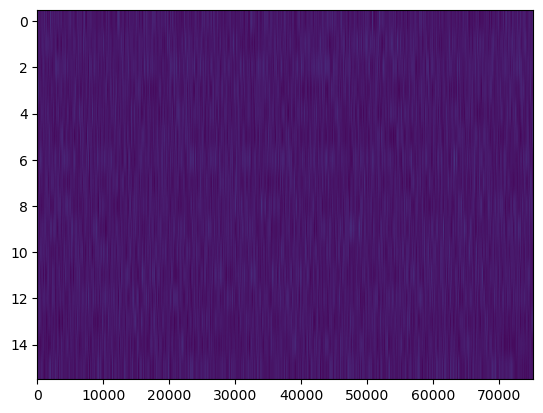

In [55]:
import matplotlib.pyplot as plt
plt.imshow(assignments_.detach().cpu().numpy(), aspect = 'auto')

In [56]:
assignments_new = {i: assignments_use[i].argmax(0) for i in assignments_use}

weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
# print(codebooks_use[0])

with torch.no_grad():

    regularization_loss = 0
    for i in range(k_magnitude_codebook):
        mask_i = magnitude_assignments == i
        assert torch.any(mask_i)
        mask_ = torch.zeros_like(mask)
        mask_[mask] = mask_i
        if i not in codebooks_use:
            weights_reconstructued_flat[mask_,:] = codebooks[i][assignments_dict[i],:] * torch.exp(magnitude_codebook_use[i])
            continue    

        weights_reconstructued_flat[mask_,:] = torch.clip(codebooks_use[i][assignments_new[i],:],-1,1) * torch.exp(magnitude_codebook_use[i])
    # weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()


    weights_reconstructued = torch.empty_like(weights)

    weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)
    # print(weights_reconstructued)

    diff = weights - weights_reconstructued
    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)


H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

loss = H_error + lambda_ * regularization_loss
print(f"average error {average_error}, H error {H_error}")

average error 0.5536376237869263, H error 5.610358715057373


In [57]:
n_change = 0
for i in codebooks_use:

    n_change += torch.sum(assignments_new[i] != assignments_dict[i])

print("n_change = ", n_change)

n_change =  tensor(0, device='cuda:6')


In [58]:
assignments_dict[0]

tensor([15, 11,  1,  ...,  2,  8,  9], device='cuda:6')

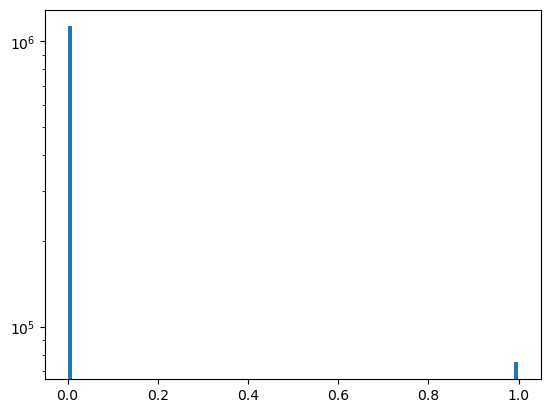

In [59]:
plt.hist(assignments_.detach().cpu().numpy().flatten(), bins = 100)
plt.yscale('log')

In [61]:
assignments_use[0][assignments_dict[0],:].detach().cpu().numpy()

array([[ 9.9999952e+00,  1.2635506e-07,  1.5326428e-07, ...,
        -5.7824224e-08, -1.2287417e-07, -4.6445859e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       ...,
       [ 5.5878967e-08,  6.5669362e-08,  7.8594709e-08, ...,
         1.0000001e+01, -6.2216365e-08, -4.7712575e-08],
       [ 1.1943567e-07,  9.9999952e+00,  9.9999924e+00, ...,
        -5.9382781e-08,  1.0000002e+01, -4.4714639e-08],
       [ 5.4991109e-08,  6.7893268e-08,  8.2246736e-08, ...,
        -6.4254273e-08, -6.5741027e-08,  1.0000002e+01]], dtype=float32)

In [62]:
codebooks[i][assignments_dict[i],:]

tensor([[ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        [ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        [ 4.3442e-02, -4.5606e-02,  7.5983e-02,  ...,  1.2069e-02,
          7.2188e-02,  1.0297e-04],
        ...,
        [-1.5629e-01,  1.7860e-01, -4.9690e-02,  ..., -1.5907e-01,
          2.4043e-02,  4.6148e-02],
        [-1.3026e-01,  3.9753e-02, -6.5690e-02,  ..., -5.2088e-02,
         -3.5687e-01,  9.4983e-02],
        [ 2.4803e-02, -3.7862e-01,  2.0537e-01,  ..., -2.6397e-02,
         -9.8013e-02, -3.7012e-02]], device='cuda:6')

In [63]:
codebooks[i]

tensor([[ 3.3170e-02, -3.2293e-01, -3.8974e-02,  ..., -4.0842e-02,
         -2.8786e-01,  3.6173e-02],
        [-6.3403e-02,  1.1116e-01, -3.1172e-01,  ..., -1.2849e-02,
         -2.9191e-02, -1.5631e-02],
        [ 2.6531e-01, -1.1728e-01, -5.6057e-02,  ..., -1.8147e-02,
         -3.2066e-01,  4.3216e-01],
        ...,
        [ 2.2107e-02,  1.5711e-01, -2.0923e-01,  ...,  5.3719e-01,
          2.7475e-01, -2.4404e-02],
        [-3.9989e-03, -4.0609e-01, -3.2776e-01,  ..., -1.5116e-04,
         -1.5891e-01, -2.2699e-02],
        [-4.6686e-02, -2.8886e-01, -8.9965e-02,  ..., -1.9055e-01,
          5.7375e-02, -3.9820e-02]], device='cuda:6')

In [ ]:
codebooks[i]

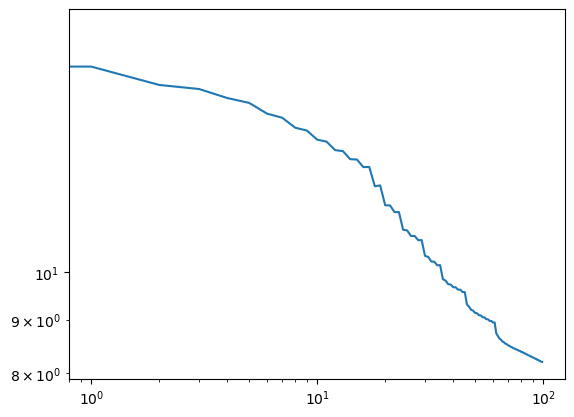

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.yscale("log")
plt.xscale("log")

In [21]:
weights

tensor([[-0.0096, -0.0301,  0.0085,  ...,  0.0178, -0.0052, -0.0365],
        [-0.0029, -0.0101,  0.0100,  ...,  0.0147,  0.0040, -0.0104],
        [-0.0004,  0.0139, -0.0074,  ..., -0.0083, -0.0070,  0.0146],
        ...,
        [-0.0107, -0.0061,  0.0310,  ..., -0.0052, -0.0143,  0.0236],
        [-0.0104, -0.0213, -0.0129,  ..., -0.0199, -0.0143, -0.0103],
        [ 0.0184,  0.0119,  0.0195,  ...,  0.0343, -0.0327, -0.0355]],
       device='cuda:7')

In [31]:
magnitude_codebook

array([[-3.5779412],
       [-2.518909 ],
       [-3.225214 ],
       [-3.9758797],
       [-2.0958226],
       [-4.47477  ],
       [-2.8797915],
       [-4.2065434],
       [-3.769462 ],
       [-3.0529354],
       [-2.329277 ],
       [-4.8156476],
       [-3.3977225],
       [-2.7026064],
       [-5.3441935],
       [-1.7897273]], dtype=float32)

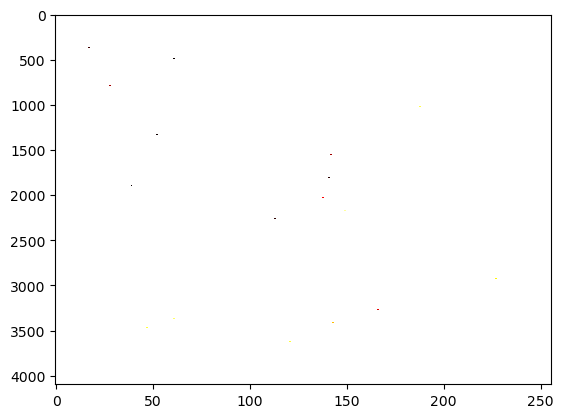

In [42]:
import matplotlib.pyplot as plt

plt.imshow(torch.log(torch.norm(H[:,row_assignments], dim = -1)).cpu().numpy(), cmap="hot", interpolation="nearest", aspect="auto")

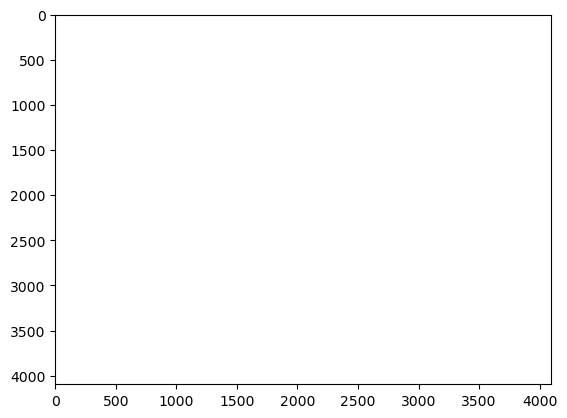

In [43]:
plt.imshow(torch.log(torch.abs(H)).cpu().numpy(), cmap="hot", interpolation="nearest", aspect="auto")

In [44]:
H

tensor([[ 1.0000e-05,  1.0000e-05, -1.0000e-05,  ..., -1.0000e-05,
          1.0000e-05, -1.0000e-05],
        [ 1.0000e-05,  1.0000e-05, -1.0000e-05,  ..., -1.0000e-05,
          1.0000e-05, -1.0000e-05],
        [-1.0000e-05, -1.0000e-05,  1.0000e-05,  ..., -1.0000e-05,
         -1.0000e-05,  1.0000e-05],
        ...,
        [-1.0000e-05, -1.0000e-05, -1.0000e-05,  ...,  1.0000e-05,
          1.0000e-05, -1.0000e-05],
        [ 1.0000e-05,  1.0000e-05, -1.0000e-05,  ...,  1.0000e-05,
          1.0000e-05,  1.0000e-05],
        [-1.0000e-05, -1.0000e-05,  1.0000e-05,  ..., -1.0000e-05,
          1.0000e-05,  1.0000e-05]], device='cuda:6')

<BarContainer object of 16 artists>

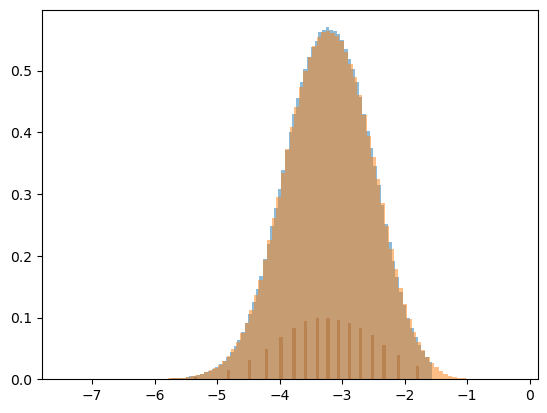

In [32]:
plt.hist(torch.log(weights_norms_masked).cpu().numpy(), bins = 100, alpha = 0.5, label = "weights",density=True)
plt.hist(torch.log(weights_norms).flatten().cpu().numpy(), bins = 100, alpha = 0.5, label = "weights_all",density=True)
plt.bar(magnitude_codebook[:,0], np.bincount(magnitude_assignments)/magnitude_assignments.shape[0], alpha = 0.5, label = "magnitude_codebook", width = 0.05, align='center')
plt.bar(magnitude_codebook_use.detach().numpy(), np.bincount(magnitude_assignments)/magnitude_assignments.shape[0], alpha = 0.5, label = "magnitude_codebook", width = 0.05, align='center')
# plt.hist(torch.log(weights_norms_masked).flatten().cpu().numpy(), bins = k_magnitude_codebook, alpha = 0.5, label = "weights_all",density=True, rwidth=0.05)

<BarContainer object of 16 artists>

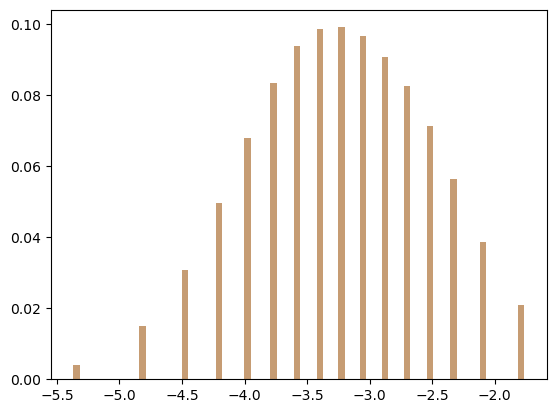

In [33]:
plt.bar(magnitude_codebook[:,0], np.bincount(magnitude_assignments)/magnitude_assignments.shape[0], alpha = 0.5, label = "magnitude_codebook", width = 0.05, align='center')
plt.bar(magnitude_codebook_use.detach().numpy(), np.bincount(magnitude_assignments)/magnitude_assignments.shape[0], alpha = 0.5, label = "magnitude_codebook", width = 0.05, align='center')

In [34]:
magnitude_codebook_use

tensor([-3.5779, -2.5189, -3.2252, -3.9759, -2.0958, -4.4748, -2.8798, -4.2065,
        -3.7695, -3.0529, -2.3293, -4.8156, -3.3977, -2.7026, -5.3442, -1.7897],
       requires_grad=True)

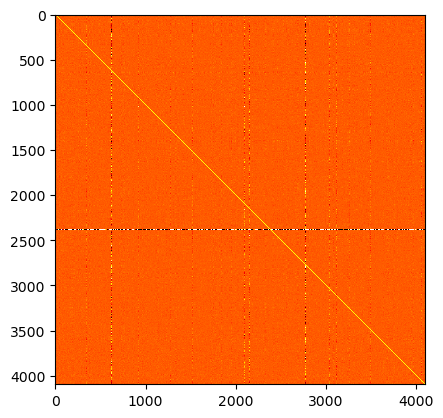

In [121]:
#divide H by its diagonal
H_ = H / torch.diag(H).unsqueeze(1)
H_ = torch.clip(H_, -2, 2)

i1 = 10000
i2 = 1250
cbar = plt.imshow(H_ .numpy(), cmap="hot", interpolation="nearest")
# plt.colorbar(cbar)

In [122]:
np.exp(magnitude_codebook[:,0][magnitude_assignments])

array([0.04895294, 0.02418004, 0.06118634, ..., 0.06118634, 0.06801527,
       0.0755034 ], dtype=float32)

In [123]:
weights_reconstructued_flat =  torch.zeros_like(weights_reshaped)

weights_reconstructued_flat[~mask,:] = weights_reshaped[~mask]
weights_reconstructued_flat[mask,:] = centriods[assignments,:] * torch.from_numpy(np.exp(magnitude_codebook[:,0][magnitude_assignments])).reshape(-1,1).float()

weights_reconstructued_flat
# weights_reconstructued = torch.zeros_like(weights)

tensor([[[ 4.6173e-04, -4.0985e-03, -1.9066e-02,  ...,  2.4387e-04,
          -2.3356e-03,  1.0368e-03],
         [ 2.4299e-05, -9.3953e-06, -6.1837e-04,  ..., -1.5436e-04,
          -1.4519e-04,  1.5833e-04],
         [ 6.1488e-05, -2.3774e-05, -1.5647e-03,  ..., -3.9059e-04,
          -3.6740e-04,  4.0065e-04],
         ...,
         [-7.4875e-04, -1.1762e-03,  2.3570e-02,  ..., -1.8039e-04,
          -2.2402e-03,  6.2147e-04],
         [-9.1646e-04, -9.3994e-04, -3.9008e-04,  ...,  3.6175e-02,
          -3.3618e-04,  1.9991e-03],
         [-7.7556e-03,  5.9658e-04, -3.7485e-04,  ...,  1.2096e-03,
           2.1439e-03, -3.7496e-02]],

        [[ 3.2830e-04, -7.9099e-03,  3.0733e-04,  ..., -5.0788e-05,
           8.5064e-03, -1.5833e-04],
         [ 5.6174e-05,  7.7114e-05, -2.1853e-04,  ..., -2.5242e-02,
           6.8013e-04, -3.6764e-04],
         [-5.6967e-04, -1.9340e-03, -2.2039e-03,  ..., -3.0491e-04,
          -1.3272e-02,  3.5321e-04],
         ...,
         [-4.0389e-04, -4

In [124]:
weights_reconstructued = torch.empty_like(weights)

weights_reconstructued[:,row_assignments] = weights_reconstructued_flat.reshape(weights_reconstructued.shape[0], -1, d)

In [125]:
weights_reconstructued


tensor([[ 4.6173e-04, -4.0985e-03, -1.9066e-02,  ...,  1.2096e-03,
          2.1439e-03, -3.7496e-02],
        [ 3.2830e-04, -7.9099e-03,  3.0733e-04,  ..., -9.6113e-05,
          1.6098e-02, -2.9963e-04],
        [-2.0733e-04,  1.7851e-02, -6.9155e-04,  ...,  8.3428e-06,
          7.6175e-04,  4.0319e-05],
        ...,
        [ 1.1142e-04,  1.5295e-04, -4.3344e-04,  ...,  1.6080e-05,
          1.4682e-03,  7.7709e-05],
        [-2.5764e-02,  5.3984e-04, -4.2009e-03,  ..., -2.8995e-04,
         -3.6007e-03,  9.9890e-04],
        [-9.1354e-04, -1.0903e-03,  8.9739e-04,  ..., -9.5208e-04,
         -4.1442e-02,  1.1029e-03]])

In [126]:
weights

tensor([[-0.0096, -0.0301,  0.0085,  ...,  0.0178, -0.0052, -0.0365],
        [-0.0029, -0.0101,  0.0100,  ...,  0.0147,  0.0040, -0.0104],
        [-0.0004,  0.0139, -0.0074,  ..., -0.0083, -0.0070,  0.0146],
        ...,
        [-0.0107, -0.0061,  0.0310,  ..., -0.0052, -0.0143,  0.0236],
        [-0.0104, -0.0213, -0.0129,  ..., -0.0199, -0.0143, -0.0103],
        [ 0.0184,  0.0119,  0.0195,  ...,  0.0343, -0.0327, -0.0355]])

In [127]:
diff = weights - weights_reconstructued

average_error = torch.sum((diff)**2)/torch.sum(weights**2)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print(f"average error {average_error}, H error {H_error}")

average error 0.5367690920829773, H error 297.4764709472656


In [128]:
mask.shape

torch.Size([4096, 512])

In [ ]:
our_cluster(torch.tensor(weights_norms_masked), k_magnitude_codebook, H_diag_use, n_iter = n_iters)

(array([1041277.,       0.,       0., 1018712.,       0.,       0.,
        1056561.,       0.,       0., 1035810.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

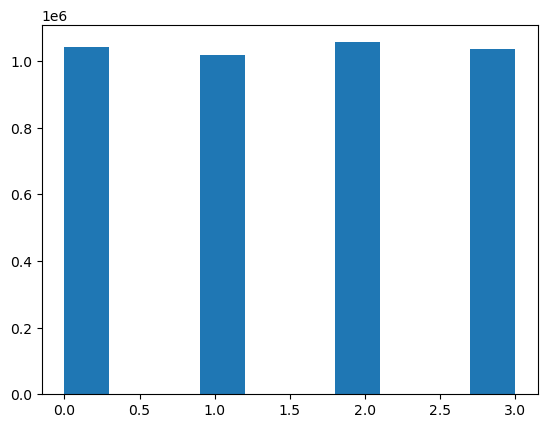

In [135]:
plt.hist(assignments.numpy())